# Analysis for PoST Parameters
The proof consists of a single nonce and several "good" labels.

In [1]:
from IPython.display import display,Math,Markdown
from scipy.stats import binom
import math
from math import log, floor, ceil, sqrt

def dm(str):
    display(Markdown(str))


## Honest Parameters

In [2]:
## Global Parameters

n = 2**35 # Total number of labels for one space unit

honest_opt_error = 2**(-10) # Honest users should fail with at most this probability with {honest_nonces} nonces.
honest_min_error = 2**(-20) # We also compute the number of nonces to achieve this error.

### Hashing-related
label_len = 8 # Label size in bytes (actually a label-block --- that is, the number of bytes of input for a single hash function invocation)
#nonces_per_hash = 128/log(n,2) # Number of nonces per hash invocation (example here is for 34-bit threshold and AES-128).
nonce_output_len = ceil(log(n,2)/8)*8
nonces_per_hash = 128 / nonce_output_len # Ensure output is aligned on byte boundaries
#nonces_per_hash = 2

## Node-specific parameters

hash_labels_per_sec = 2**27 # Number of hash invocations per second. ; this is a "fast" CPU
read_mb_per_sec = 200 # Disk read speed in MB/s ; this is a fast machine
scrypt_per_sec = 2**13

hash_labels_per_sec_slow = 2**26 # Number of hash invocations per second. ; this is a "slow" CPU
read_mb_per_sec_slow = 150 # Disk read speed in MB/s ; this is a slow machine
scrypt_per_sec_slow = 2**11.843


# Maximum expected time for "slow" machines to spend doing rate-limiting PoW (in seconds). [We don't currently use this value]
max_honest_rate_limiting_pow_overhead = 240


## Adversarial Parameters

We use these parameters to compute the minimal number of good labels needed.

In [3]:
# Minimal fraction of data that the adversary stores
#c = 0.80 
c = 0.75 

# Multiplicative advantage for adversary in solving rate-limiting PoW vs CPU-solving honest party
adv_pow_advantage = 1000 # If fastest adversary solves PoW in 1 second, then honest user on CPU takes `adv_pow_advantage` seconds.

adv_init_time = 60*60*24 # Adversarial initialization time (for a single space unit) in seconds

# maximum number of adversarial nonces. Trying this number of nonces should be as expensive as initializing the unstored part of the adversary's claimed space.
adv_nonces = 8e6


In [4]:

# Display the calculations for a proof that requires $k$ good labels out of $n$, where each label is good with probability $p$.
def display_results(k, n, p):
    actualq = binom.sf(k,n,p) # Actual probability of finding at least k good labels out of n (might differ from q due to rounding)
    adv_prob = binom.sf(k, ceil(c*n), p)
    adv_log_prob = binom.logsf(k, ceil(c*n), p)/log(2)

    if actualq == 0 or actualq == 1 or log(1-actualq) == 0:
        dm(rf"**Warning**: actualq=${actualq:.2f}=2^{{ {log(actualq,2):.2f} }}$")
        
    
    opt_nonces = ceil(log(honest_opt_error)/log(1-actualq))
    honest_actual_error = (1-actualq)**opt_nonces
    
    expected_nonces = ceil(1/actualq)
    # expected_batches = ceil(expected_nonces / honest_nonce_batch)

    max_nonces = ceil(log(honest_min_error)/log(1-actualq))

    adv_success_log_prob = binom.logsf(0, adv_nonces, adv_prob)/log(2) # We use the binom.logsf function rather than directly computing because it handles the underflows more nicely.
        
    dm(rf"""### Proof consists of a single nonce with {k} good labels

* Proof size is ${k *ceil(log(n,256))}$ bytes. 
* Verification cost is ${k}$ scrypt evaluations.
    
For honest users: $q=\Pr[Binom(n=2^{{ {log(n,2):.2f} }}, p={p*n:.2f}/n) \ge {k}] = {binom.sf(k,n,p):.2f} = 2^{{ {binom.logsf(k,n,p)/log(2):.2f} }}$
  *  Expected number of nonces for honest parties is {expected_nonces} ({ceil(expected_nonces/nonces_per_hash)} hash invocations per label)
  *  Need {opt_nonces} nonces to ensure honest failure probability of less than $2^{{ {log(honest_actual_error,2):.2f} }} \le 2^{{ {log(honest_opt_error,2):.2f} }}$
  *  Need {max_nonces} nonces to ensure honest failure probability of less than $2^{{ {log(honest_min_error,2):.2f} }}$
  
For the adversary: $\Pr[Binom({c:.2f}\cdot n, p={p*n:.2f}/n) \ge {k}] = {adv_prob:.2f} = 2^{{ {adv_log_prob:.2f} }}$
  *  Expected number of nonces for adversary is ${floor(1/adv_prob)}=2^{{ {-adv_log_prob:.2f} }}$
  *  With $2^{{ {log(adv_nonces,2):.2f} }}$ nonce attempts, probability that adversary succeeds is less than $2^{{ {adv_success_log_prob:.2f} }}$
""")
    

## Inverse calculations and optimizations

### Finding $p$ given $k$ and $q$

In [5]:
from scipy import optimize

k = 2000
q = 0.47

# Find the p that minimizes, for a binomially distributed variable Binom with parameters n,p, the error
# |Pr[Binom(n,p) >= k] - q|. 
def find_p(k2: int, n1: int, q1: float):
    """Find p such that Pr[X \ge k]=q when X~Binom(n,p)"""
    def p_error(k1):
        if k1 <= 0: 
            return math.inf
        actualq = binom.sf(k2,n1,k1/n1)
        if actualq == 0 or q > 2**(-20) and actualq < 2**(-40):
            return 3-k1/n1
        elif actualq == 1 or q < (1-2**(-20)) and actualq > (1-2**(-40)):
            return 2+k1/n1
        return (q1 - actualq)**2

    bounds=(0, 3*k2)
        
    res = optimize.minimize_scalar(p_error,bounds=bounds, method='bounded', options={'xatol': 2**(-64), 'maxiter': 2**20})
        
    return res.x/n1

p = find_p(k,n,q)

# Finding q given p
def find_q_given_p(k, n, p):
    return binom.sf(k, n, p)

dm(rf"Best solution found is $p=2^{{ {log(p,2):.3f} }} = \frac{{ {p*n:.2f} }} {{ n }}$")
dm(rf"$\Pr[Binom(n=2^{{ {log(n,2):.2f} }}, p={p*n:.2f}/n \ge {k}] = {find_q_given_p(k,n,p):.2f}$")

Best solution found is $p=2^{ -24.036 } = \frac{ 1997.30 } { n }$

$\Pr[Binom(n=2^{ 35.00 }, p=1997.30/n \ge 2000] = 0.47$

### Finding $q$

We're trying to maximize the gap between the honest success probability and the adversarial success. This gap grows with the inverse of $q$, so the optimal $q$ is just bounded by the honest success probability (or, equivalently, by the expected number of nonces the honest parties must try)

In [6]:
# Find q that guarantees honest users will succeed with honest_nonces except with probability honest_opt_error
def find_q(honest_opt_error, honest_nonces):
    return 1-(honest_opt_error)**(1/honest_nonces)

def find_q_from_expected_nonces(expected_honest_nonces):
    return 1/expected_honest_nonces

### Optimizing Honest Nonces
Here, we're trying to find the maximum number of nonces that allow honest users on "fast" computers to read at I/O speed.

In [7]:

# Number of nonces that succeed with probability `percentile`
def percentile_honest_nonces(q, percentile):
    if q == 1:
        return 1
    return ceil(log(1-percentile)/log(1-q))

# number of parallel nonces to equalize read time and hashing time (not necessarily an integer)
def break_even_nonces(hash_labels_per_sec, read_labels_per_sec):
    return hash_labels_per_sec / read_labels_per_sec * nonces_per_hash


read_labels_per_sec_fast = read_mb_per_sec * 2**20 / label_len
break_even_fast_nonces = break_even_nonces(hash_labels_per_sec, read_labels_per_sec_fast)

q = find_q(2**(-20), floor(break_even_fast_nonces))

dm(rf"""
* Break-even nonces for fast nodes: {break_even_fast_nonces:.2f} ({break_even_fast_nonces/nonces_per_hash} hash invocations)
* $q={q:.2f}$ for {floor(break_even_fast_nonces)} nonces to succeed except with probability ${honest_opt_error:.3f} = 2^{{ {log(honest_opt_error,2):.2f} }}$
""")



* Break-even nonces for fast nodes: 16.38 (5.12 hash invocations)
* $q=0.58$ for 16 nonces to succeed except with probability $0.001 = 2^{ -10.00 }$


### Optimizing Parallel Nonces for Slower Nodes

In [8]:

# Actual labels-per-second for a given number of parallel nonces (this is either dominated by hash speed or by read speed)
def labels_per_sec(hash_labels_per_sec, read_labels_per_sec, parallel_nonces):
    hashes_per_label = ceil(parallel_nonces/nonces_per_hash) # Have to perform an integer number of hashes
    return min(hash_labels_per_sec / hashes_per_label, read_labels_per_sec)

def expected_total_passes(parallel_nonces, q):
    q1 = 1-(1-q)**parallel_nonces # Probability of success in a single pass.
    return 1/q1

# Number of passes that succeed with probability `percentile`
def percentile_total_passes(parallel_nonces, q, percentile):
    q1 = 1-(1-q)**parallel_nonces # Probability of success in a single pass.
    if q1 == 1:
        return 1
    return ceil(log(1-percentile)/log(1-q1))

def expected_total_time_per_label(hash_labels_per_sec, read_labels_per_sec, parallel_nonces, q):
    return expected_total_passes(parallel_nonces, q) / labels_per_sec(hash_labels_per_sec, read_labels_per_sec, parallel_nonces)


def percentile_total_time_per_label(hash_labels_per_sec, read_labels_per_sec, parallel_nonces, q, percentile):
    return percentile_total_passes(parallel_nonces, q, percentile) / labels_per_sec(hash_labels_per_sec, read_labels_per_sec, parallel_nonces)


def find_parallel_nonces(hash_labels_per_sec, read_labels_per_sec, q):
    def exp_time(parallel_nonces):
        return expected_total_time_per_label(hash_labels_per_sec, read_labels_per_sec, parallel_nonces, q)
    
    break_even = break_even_nonces(hash_labels_per_sec, read_labels_per_sec)
    res = optimize.minimize_scalar(exp_time, bounds=(0, 5*ceil(break_even)), method='bounded', options={'xatol': 0.1, 'maxiter': 2000})
    if exp_time(ceil(res.x)) > exp_time(floor(res.x)):
        return floor(res.x)
    else:
        return ceil(res.x)

def time_per_pass(hash_labels_per_sec, read_labels_per_sec, q):
    parallel_nonces = find_parallel_nonces(hash_labels_per_sec, read_labels_per_sec, q)
    expected_time_per_label = expected_total_time_per_label(hash_labels_per_sec, read_labels_per_sec, parallel_nonces,q)
    time_per_pass = expected_time_per_label * n / 60
    return time_per_pass

def percentile_time_per_pass(hash_labels_per_sec, read_labels_per_sec, q, percentile):
    parallel_nonces = find_parallel_nonces(hash_labels_per_sec, read_labels_per_sec, q)
    percentile_time_per_label =  percentile_total_time_per_label(hash_labels_per_sec, read_labels_per_sec, parallel_nonces, q, percentile)
    time_per_pass = percentile_time_per_label * n / 60
    return time_per_pass


def display_optimized_nonces(hash_labels_per_sec, read_labels_per_sec, q, n):
    parallel_nonces = find_parallel_nonces(hash_labels_per_sec, read_labels_per_sec, q)
    mb_per_sec = read_labels_per_sec * label_len / 2**20
    expected_time_per_label = expected_total_time_per_label(hash_labels_per_sec, read_labels_per_sec, parallel_nonces,q)
    p99_per_label = percentile_total_time_per_label(hash_labels_per_sec, read_labels_per_sec, parallel_nonces,q, 0.99)
    
    dm(rf"""#### Optimized execution for $q={q:.2f}$, $2^{{ {log(hash_labels_per_sec,2):.2f} }}$ hashes/sec, ${mb_per_sec:.2f}$ MB/sec read rate
* Optimal number of parallel nonces: {parallel_nonces}
  - {ceil(parallel_nonces/nonces_per_hash)} hash invocations
  - will take {expected_total_passes(parallel_nonces,q):.6f} passes in expectation
  - Expected total time per label is {expected_time_per_label:.2e} seconds.
      - 99${{}}^{{th}}$-percentile time per label is {p99_per_label:.2e} seconds
  - Expected total time for $2^{{ {log(n,2):.2f} }}$ labels is ${expected_time_per_label * n / 60:.2f}$ minutes.
      - 99${{}}^{{th}}$-percentile total time is {p99_per_label * n / 60:.2f} minutes
""")

q=1/9
display_optimized_nonces(hash_labels_per_sec, read_labels_per_sec_fast, q, n)

read_labels_per_sec_slow = read_mb_per_sec_slow * 2**20 / label_len
display_optimized_nonces(hash_labels_per_sec_slow, read_labels_per_sec_slow, q, n)

#### Optimized execution for $q=0.11$, $2^{ 27.00 }$ hashes/sec, $200.00$ MB/sec read rate
* Optimal number of parallel nonces: 16
  - 5 hash invocations
  - will take 1.179107 passes in expectation
  - Expected total time per label is 4.50e-08 seconds.
      - 99${}^{th}$-percentile time per label is 1.14e-07 seconds
  - Expected total time for $2^{ 35.00 }$ labels is $25.76$ minutes.
      - 99${}^{th}$-percentile total time is 65.54 minutes


#### Optimized execution for $q=0.11$, $2^{ 26.00 }$ hashes/sec, $150.00$ MB/sec read rate
* Optimal number of parallel nonces: 9
  - 3 hash invocations
  - will take 1.530080 passes in expectation
  - Expected total time per label is 7.78e-08 seconds.
      - 99${}^{th}$-percentile time per label is 2.54e-07 seconds
  - Expected total time for $2^{ 35.00 }$ labels is $44.57$ minutes.
      - 99${}^{th}$-percentile total time is 145.64 minutes


### Optimizing $k$ given $q$

In [9]:
# Find the smallest k that requires the adversary to search through min_adv_nonces in expectation to find a solution.

def find_k(q: float, n1: int, c1: float, min_log_adv_nonces: int):
    def k_error(k):
        k = ceil(k)
        p = find_p(k, n1, q)
        
        adv_log_prob = binom.logsf(k, ceil(c1*n1), p)/log(2)
        expected_log_nonces = -adv_log_prob
        
        if expected_log_nonces < min_log_adv_nonces:
            return math.inf
        else:
            return k
    
    res = optimize.minimize_scalar(k_error, bounds=(16, 1000), method='bounded', options={'xatol': 0.5, 'maxiter': 2000})
    return res.x


# Use q computed above
k = find_k(q, n,c,log(adv_nonces,2))
k = ceil(k)
p = find_p(k,n,q)


display_results(k,n,p)


### Proof consists of a single nonce with 217 good labels

* Proof size is $1085$ bytes. 
* Verification cost is $217$ scrypt evaluations.
    
For honest users: $q=\Pr[Binom(n=2^{ 35.00 }, p=200.15/n) \ge 217] = 0.11 = 2^{ -3.17 }$
  *  Expected number of nonces for honest parties is 9 (3 hash invocations per label)
  *  Need 59 nonces to ensure honest failure probability of less than $2^{ -10.03 } \le 2^{ -10.00 }$
  *  Need 118 nonces to ensure honest failure probability of less than $2^{ -20.00 }$
  
For the adversary: $\Pr[Binom(0.75\cdot n, p=200.15/n) \ge 217] = 0.00 = 2^{ -22.97 }$
  *  Expected number of nonces for adversary is $8236742=2^{ 22.97 }$
  *  With $2^{ 22.93 }$ nonce attempts, probability that adversary succeeds is less than $2^{ -0.69 }$


## Optimizing $q$ given $k$ and `min_adv_nonces`

Here, we want to fix $k$ and find the largest value of $q$ for which the adversary still requires `min_adv_nonces` in expectation.

In [10]:
def find_p_given_k(k: int, n1: int, c1: float, min_log_adv_nonces: int):
    def p_error(k1):
        p = k1/n1
        
        if p == 0:
            return math.inf
        
        adv_log_prob = binom.logsf(k, ceil(c1*n1), p)/log(2)
        expected_log_nonces = -adv_log_prob
        
        if expected_log_nonces < min_log_adv_nonces:
            return k1
        else:
            return -k1
    
    res = optimize.minimize_scalar(p_error, bounds=(0, 5*k), method='bounded', options={'xatol': 2**(-64), 'maxiter': 2**20})
    if not res.success:
        dm("**Warning**: `find_p_given_k` optimization unsuccessful!")
    return res.x / n


k=600
p = find_p_given_k(k, n, c, log(adv_nonces,2))
q = find_q_given_p(k, n, p)

display_results(k,n,p)
display_optimized_nonces(hash_labels_per_sec, read_labels_per_sec_fast, q, n)
display_optimized_nonces(hash_labels_per_sec_slow, read_labels_per_sec_slow, q, n)

### Proof consists of a single nonce with 600 good labels

* Proof size is $3000$ bytes. 
* Verification cost is $600$ scrypt evaluations.
    
For honest users: $q=\Pr[Binom(n=2^{ 35.00 }, p=643.96/n) \ge 600] = 0.96 = 2^{ -0.06 }$
  *  Expected number of nonces for honest parties is 2 (1 hash invocations per label)
  *  Need 3 nonces to ensure honest failure probability of less than $2^{ -13.70 } \le 2^{ -10.00 }$
  *  Need 5 nonces to ensure honest failure probability of less than $2^{ -20.00 }$
  
For the adversary: $\Pr[Binom(0.75\cdot n, p=643.96/n) \ge 600] = 0.00 = 2^{ -22.93 }$
  *  Expected number of nonces for adversary is $8000005=2^{ 22.93 }$
  *  With $2^{ 22.93 }$ nonce attempts, probability that adversary succeeds is less than $2^{ -0.66 }$


#### Optimized execution for $q=0.96$, $2^{ 27.00 }$ hashes/sec, $200.00$ MB/sec read rate
* Optimal number of parallel nonces: 12
  - 4 hash invocations
  - will take 1.000000 passes in expectation
  - Expected total time per label is 3.81e-08 seconds.
      - 99${}^{th}$-percentile time per label is 3.81e-08 seconds
  - Expected total time for $2^{ 35.00 }$ labels is $21.85$ minutes.
      - 99${}^{th}$-percentile total time is 21.85 minutes


#### Optimized execution for $q=0.96$, $2^{ 26.00 }$ hashes/sec, $150.00$ MB/sec read rate
* Optimal number of parallel nonces: 9
  - 3 hash invocations
  - will take 1.000000 passes in expectation
  - Expected total time per label is 5.09e-08 seconds.
      - 99${}^{th}$-percentile time per label is 5.09e-08 seconds
  - Expected total time for $2^{ 35.00 }$ labels is $29.13$ minutes.
      - 99${}^{th}$-percentile total time is 29.13 minutes


## Computing Rate-limiting PoW difficulty and time

In [11]:

def display_pow_times(c, adv_init_time, adv_pow_advantage, adv_nonces, q):
    # Total time that all the rate-limiting PoWs together should take for the adversary (in seconds)
    adv_total_rate_limiting_pow_time = adv_init_time * (1-c)

    honest_pow_time_per_nonce = adv_total_rate_limiting_pow_time * adv_pow_advantage / adv_nonces
    total_expected_honest_pow_time = honest_pow_time_per_nonce / q


    dm(rf"""
* Total PoW time for adversary: {adv_total_rate_limiting_pow_time / (60*60):.2f} hours
   - Per-nonce$\times$space-unit difficulty for adversary should be {adv_total_rate_limiting_pow_time / adv_nonces:.3f} seconds
   - This means each nonce-block$\times$space-unit PoW should have difficulty {nonces_per_hash*adv_total_rate_limiting_pow_time / adv_nonces:.3f} seconds
* Total expected PoW time for honest party: {total_expected_honest_pow_time:.2f} seconds
   - Expected per-nonce$\times$space-unit PoW time for honest party: {honest_pow_time_per_nonce:.2f} seconds (each per-nonce PoW should be a $2^{{ {log((1-c)/adv_nonces,2):.2f} }}$ fraction of the total number of PoST init hashes).
* Total 99${{}}^{{th}}$-percentile PoW time for honest party: {percentile_honest_nonces(q, .99)*honest_pow_time_per_nonce:.2f} seconds
    """)
    
display_pow_times(c, adv_init_time, adv_pow_advantage, adv_nonces, q)


* Total PoW time for adversary: 6.00 hours
   - Per-nonce$\times$space-unit difficulty for adversary should be 0.003 seconds
   - This means each nonce-block$\times$space-unit PoW should have difficulty 0.009 seconds
* Total expected PoW time for honest party: 2.82 seconds
   - Expected per-nonce$\times$space-unit PoW time for honest party: 2.70 seconds (each per-nonce PoW should be a $2^{ -24.93 }$ fraction of the total number of PoST init hashes).
* Total 99${}^{th}$-percentile PoW time for honest party: 5.40 seconds
    

# Nice graphs

In [12]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

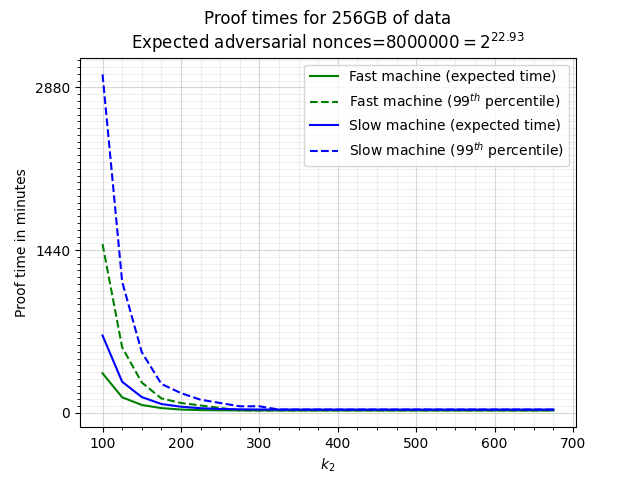

(Major grid lines on y axis are days, minor grid lines are hours)

In [13]:
from_k,to_k,step_k = 100, 700, 25

k_arr = np.arange(from_k, to_k, step_k)
p_vals = { k: find_p_given_k(k, n, c, log(adv_nonces,2)) for k in k_arr }
q_vals = { k: find_q_given_p(k, n, p_vals[k]) for k in k_arr }



fig, ax = plt.subplots()

ax.plot(k_arr, [time_per_pass(hash_labels_per_sec,read_labels_per_sec_fast, q_vals[k]) for k in k_arr], 'g-', label="Fast machine (expected time)")
ax.plot(k_arr, [percentile_time_per_pass(hash_labels_per_sec,read_labels_per_sec_fast, q_vals[k],0.99) for k in k_arr], 'g--', label="Fast machine ($99^{th}$ percentile)")
ax.plot(k_arr, [time_per_pass(hash_labels_per_sec_slow,read_labels_per_sec_slow, q_vals[k]) for k in k_arr], 'b-', label="Slow machine (expected time)")
ax.plot(k_arr, [percentile_time_per_pass(hash_labels_per_sec_slow,read_labels_per_sec_slow, q_vals[k],0.99) for k in k_arr], 'b--', label="Slow machine ($99^{th}$ percentile)")



ax.set_xticks(k_arr, minor=True)
ymin,ymax = ax.get_ylim()
ax.set_yticks(np.arange(0, ymax, 60*24))
ax.set_yticks(np.arange(0, ymax, 60), minor=True)
ax.grid(axis='both', which='major', alpha=0.5)
ax.grid(axis='both', which='minor', alpha=0.2)

plt.title(rf"Proof times for {n*label_len/2**30:.0f}GB of data" + "\n" + rf"Expected adversarial nonces=${adv_nonces:.0f}=2^{{ {log(adv_nonces,2):.2f} }}$")
plt.xlabel('$k_2$')
plt.ylabel('Proof time in minutes')
plt.legend(loc="upper right")

plt.show()
dm("(Major grid lines on y axis are days, minor grid lines are hours)")

# Fiat-Shamir Post Proof
1. Prover finds a nonce and $k$ "good" label indices
    - Prover must solve a proof-of-work `pow1` with PoST challenge and nonce as its challenge. Denote $W_1$ the expected cost of a `pow1` solution.
2. The indices are then hashed (not the labels themselves), to produce a random subset of $k_3$ indices (out of the original $k$). 
    - Prover must solve a proof-of-work `pow2` with set of indices, in addition to nonce and PoST challenge as its challenge. Denote $W_2$ the expected cost of a `pow2` solution.
3. Proof consists of:
   - The nonce, 
   - $k$ indices. 
   - `pow1`, `pow2`
4. Verifier:
    - checks both proofs of work, 
    - hashes the $k$ indices to find the $k_3$ subset
    - computes $B\cdot k_3$ scrypt-hashes  (to reconstruct the labels), where $B$ is the number of PoST table cells in each label.
    - verifies that all the labels (of the $k_3$) are good.


The intuition for the security analysis is as follows:
* The adversary first must pay $W_1$ to solve `pow1`. 
* For `pow1` solution $i$, it can run over its $c\cdot n$ labels "for free"; denote $c'_i = k'_i/k$, where $k'_i$ is the number of good labels it found.
    - Note that it doesn't matter whether it chooses a new nonce or just a new `pow1` with the same nonce.
* Given $c'_i$, it can decide whether to solve `pow2` and get a good output set (with probability $(c'_i)^{k_3}$), or try another solution to `pow1` (and hopefully get a larger $c'_{i+1}$.
* Since the attempts are independent, if the better strategy is to solve `pow2` this will still be the case even if the first attempt fails. Thus, the optimal strategy is, for some value `\tau`, to solve `pow1` until $c'_i\ge \tau$, and then solve `pow2` until it finds a good proof.
* Given $\tau$, $c$, $k$, $k_3$ and $p$, we can compute the expected cost to the adversary as follows:
    - Let $X$ be a random variable denoting the number of `pow1` attempts until $c' \ge \tau$, and $Y$ the number of attempts until a good set is found by repeatedly trying `pow2`. Then the total cost to the adversary is $W_1\cdot X + W_2\cdot Y$. 
    - The expected cost is thus $W_1\cdot E(X)+W_2\cdot E(Y)$.
    - Since $c'_i \ge \tau \Leftrightarrow k'_i \ge \tau \cdot k$, and $k'_i$ is binomially distributed with parameters $c\cdot n$ and $p$,  then 
      $$ E(X)=1/\Pr{[B(c\cdot n,p)\ge \tau\cdot k]} $$. 
    - The distribution of $Y$ can be constructed by first sampling $k'\sim B(c\cdot n,p)|k'/k\ge \tau$, and then sampling from the geometric distribution with parameter $c'=k'/k$.  So $$  
    E(Y) = \frac{1}{\Pr{[B(c\cdot n,p)\ge \tau\cdot k]}}\sum_{k'=\lceil \tau \cdot k \rceil}^{c\cdot n} \Pr{\left[ B(c\cdot n,p)=k' \right]}E(Y|c'=k'/k) =  
        \frac{1}{\Pr{[B(c\cdot n,p)\ge \tau\cdot k]}}\sum_{k'=\lceil \tau \cdot k \rceil}^{c\cdot n} \Pr{\left[ B(c\cdot n,p)=k' \right]}\left( \frac{k'}{k}\right)^{-k_3} 
    $$
    
    - Putting things together, the total expected cost is
    $$
    W_1\cdot E(X)+W_2\cdot E(Y) = \frac{1}{\Pr{[B(c\cdot n,p)\ge \tau\cdot k]}} \left( W_1 + W_2 \cdot \sum_{k'=\lceil \tau \cdot k \rceil}^{c\cdot n} \Pr{\left[ B(c\cdot n,p)=k' \right]}\left( \frac{k'}{k}\right)^{-k_3} \right)
    $$
    
    

In [14]:
def expected_Y(tau, c, k, k3, n, p):
    max_kprime = ceil(c*n)
    min_kprime = ceil(tau*k)
    
    total = 0
    for kprime in range(min_kprime, max_kprime):
        total += binom.pmf(kprime, c*n, p) * (kprime / k) ** (-k3)
        
    total /= binom.sf(tau*k, ceil(c*n), p)
    
    return total
    
# The exact calculation is too computationally expensive when n is large
# We approximate by not counting k' values far from the expectation 
# (specifically, we check the range min_kprime,max_kprime such that the probability that
# k' is outside the range is less than 2eps)
# The function returns a tuple (expY_min, exp_Y_max), such that
# the actual expectation is in this range.
# bound on the uncounted values
def approximate_expected_Y(tau, c, k, k3, n, p, eps):
    min_kprime = max(floor(binom.ppf(eps, ceil(c*n), p)), ceil(tau*k))
    max_kprime = max(ceil(binom.isf(eps, ceil(c*n), p)), min_kprime+1)
    #dm(rf""" $k'_{{max}}={max_kprime}$; $k'_{{min}}={min_kprime}$ """)
    
    conditional_scaling_factor = binom.sf(tau*k, ceil(c*n), p) # We condition on k'>= tau*k
    
    max_err = binom.sf(max_kprime, ceil(c*n), p)*(k/max_kprime)**k3 
    if min_kprime > ceil(tau*k):
        max_err += binom.cdf(min_kprime - 1, ceil(c*n), p) * tau**(-k3) 
    max_err /= conditional_scaling_factor
        
    total = 0
    for kprime in range(min_kprime, max_kprime):
        total += binom.pmf(kprime, ceil(c*n), p) * (kprime / k) ** (-k3)
        
    total /= conditional_scaling_factor
    
    return total, total+max_err
    

# Using the approximation for Y, and the formula above for expected total cost:
def approximate_total_cost(tau, w1, w2, c, k, k3, n, p, eps):
    conditional_scaling_factor = binom.sf(tau*k, ceil(c*n), p) # We condition on k'>= tau*k
    
    y_cost_min, y_cost_max = approximate_expected_Y(tau, c, k, k3, n, p, eps)
    y_cost_min *= w2
    y_cost_max *= w2
    x_cost = w1/conditional_scaling_factor
    
    return x_cost + y_cost_min, x_cost + y_cost_max
    

# Now we can determine the optimal value of tau (for the adversary) given all the other parameters
def find_optimal_tau(w1, w2, c, k, k3, n, p, eps):
    def cost_error_min(tau):
        return approximate_total_cost(tau, w1, w2, c, k, k3, n, p, eps)[0]
    
    def cost_error_max(tau):
        return approximate_total_cost(tau, w1, w2, c, k, k3, n, p, eps)[1]
    
    
    res_min = optimize.minimize_scalar(cost_error_min, bounds=(c*n*p/k, 1), method='bounded', options={'xatol': 2**(-64), 'maxiter': 2**20})
    res_max = optimize.minimize_scalar(cost_error_max, bounds=(c*n*p/k, 1), method='bounded', options={'xatol': 2**(-64), 'maxiter': 2**20})
    
    return res_min.x, res_max.x

# Returns a lower bound on the optimal adversarial cost given the parameters.
def find_optimal_adv_cost(w1, w2, c, k, k3, n, p, eps):
    tau_min, tau_max = find_optimal_tau(w1, w2, c, k, k3, n, p, eps)
    
    return min( approximate_total_cost(tau_min, w1, w2, c, k, k3, n, p, eps) + approximate_total_cost(tau_max, w1, w2, c, k, k3, n, p, eps) )




### Finding $W_1$ and $W_2$

The honest cost of work for the proof depends on the number of nonces the honest party must try, since it pays $W_1$ for every nonce, and then $W_2$ once.
The adversarial factor (the multiplicative factor in the expected adversarial cost compared to the expected honest cost) changes with the ratio of $W_1$ to $W_2$.  
We set $W_1$ and $W_2$ such that this adversarial factor is maximized.

In [15]:

# Keeping total honest cost at 1, and letting w2_frac be the fraction of the honest cost solving `pow2` and honest_nonces the expected number of nonces
# honest parties must try, return the expected work parameters `w1` for `pow1` and `w2` for `pow2` required to achieve this.
def w1_w2_from_w2_frac(w2_frac, honest_nonces):
    return (1-w2_frac)/honest_nonces, w2_frac 

# Find the w1/w2 combination that maximizes the expected adversarial cost, while keeping the honest cost at 1.
# Returns a tuple (w2_frac, adv_cost) where w2_frac is the fraction of the honest cost spent on pow2 and adv_cost is the expected adversarial cost.
def find_optimal_w2_frac(honest_nonces, c, k, k3, n, p, eps, disp=0):
    
    def w2_frac_error(w2_frac):
        w1, w2 = w1_w2_from_w2_frac(w2_frac, honest_nonces)
        return -find_optimal_adv_cost(w1, w2, c, k, k3, n, p, 2**(-30)) 
    
    res = optimize.minimize_scalar(w2_frac_error, bounds=(0.4, 0.999), method='bounded', options={'disp': disp, 'xatol': 2**(-64), 'maxiter': 2**20})
    
    return res.x, -res.fun


### Finding minimal $k$ (or minimal $k_3$)

In [16]:
from bisect import bisect_left


# Find the smallest k that will give adv_cost_factor expected cost to the adversary with given k3
def find_minimal_k(adv_cost_factor, c, k3, q, n, eps, disp=0):
    honest_nonces = 1/q
    
    def get_work(k):
        p = find_p(k, n, q)
        work = find_optimal_w2_frac(honest_nonces, c, k, k3, n, p, eps, disp=disp)[1]
        if disp > 0:
            dm(rf"`find_minimal_k.get_work`($k={k}$): work={work:.2e}")
        return work
    
    min_val, max_val = 100, 8000
    return bisect_left(range(min_val,max_val), adv_cost_factor, key=get_work) + min_val

# Find the smallest k3 that will give adv_cost_factor expected cost to the adversary with given k
def find_minimal_k3(adv_cost_factor, c, k, q, n, eps, disp=0):
    honest_nonces = 1/q
    p = find_p(k, n, q)
    
    def get_work(k3):
        work = find_optimal_w2_frac(honest_nonces, c, k, k3, n, p, eps, disp)[1]
        if disp > 0:
            dm(rf"`find_minimal_k3.get_work`($k_3={k3}$): work={work:.2e}")
        return work
    
    min_val, max_val = 40, min(k,300)
    return bisect_left(range(min_val,max_val), adv_cost_factor, key=get_work) + min_val



### Adversary's optimal $c$ for given parameters

Let $I$ be an upper bound on the unit storage cost, measured in "honest proof cost units".  That is, the cost of storing an entire space unit should be at most $I$ times the PoW cost of an honest PoST proof. By design, the initialization cost is such an upper bound.

The adversary pays at most $c\cdot  I$ for storage, and an additional $W(c)$ for grinding on the proof PoW. (We note that the adversary may pay *less* for storage, since $I$ is merely an upper bound; however the lower the storage cost the lower the advantage for the adversary --- since it can gain an advantage only by replacing storage with work, and this advantage is monotonically lower the lower the storage cost)

Below, we try to find the value of $c$ that minimizes the total adversarial work; this should give us a bound on the adversarial advantage over the honest user.

In [24]:
def find_optimal_c(I, w1, w2, k, k3, q, n, eps, disp=0):
    honest_nonces = 1/q
    p = find_p(k, n, q)
    
    def get_work(c):
        work = find_optimal_adv_cost(w1, w2, c, k, k3, n, p, eps)
        if disp > 0:
            dm(rf"`find_optimal_c`($I=2^{{ {log(I,2)} }}$, $k={k}$, $k_3={k3}$, $n=2^{{ {log(n,2)} }}$, $p={n*p:.1f}/n$, $\epsilon=2^{{ { log(eps,2) } }} $)`.get_work`($c={c}$): work={work:.2e}")
        return I*c+work
        
    res = optimize.minimize_scalar(get_work, bounds=(0, 1), method='bounded', options={'disp': disp, 'xatol': 2**(-64), 'maxiter': 2**20})
    
    return res.x, res.fun

In [87]:
k = 300
honest_nonces = 9
q = find_q_from_expected_nonces(honest_nonces)
p = find_p(k, n, q)
c = 0.65
eps=2**(-30)
adv_cost_factor = 1e5

dm(rf"Finding optimal $k_3$ for $k={k}$")
k3 = find_minimal_k3(adv_cost_factor, c, k, q, n, eps, disp=1)
w2_frac, work = find_optimal_w2_frac(honest_nonces, c, k, k3, n, p, eps)
dm(rf"For $k={k}$, $c={c}$, calculated $k_3={k3}$ (work={work:.2e})")

Finding optimal $k_3$ for $k=300$

`find_minimal_k3.get_work`($k_3=170$): work=7.22e+07

`find_minimal_k3.get_work`($k_3=105$): work=2.73e+06

`find_minimal_k3.get_work`($k_3=72$): work=1.93e+05

`find_minimal_k3.get_work`($k_3=56$): work=3.76e+04

`find_minimal_k3.get_work`($k_3=64$): work=8.82e+04

`find_minimal_k3.get_work`($k_3=68$): work=1.32e+05

`find_minimal_k3.get_work`($k_3=66$): work=1.08e+05

`find_minimal_k3.get_work`($k_3=65$): work=9.75e+04

For $k=300$, $c=0.65$, calculated $k_3=66$ (work=1.08e+05)

### Set your own $k=k_2$ and $k_3$
Here you set $k$ ($k_2$), $k_3$ and the expected number of nonces to arbitrary values, and compute the other parameters

In [105]:
# Set the parameters here
k = 300
k3 = 60
honest_nonces = 9

nonces_per_hash = 128 / nonce_output_len # Ensure output is aligned on byte boundaries
#nonces_per_hash = 2


I = 2**25 # how much should a unit of initialization cost in "honest proof PoWs"
          # (i.e., computing the PoWs for this many honest proofs for one space unit should be equivalent to initializing a unit of space)

# Starting c value (we work "best" against an adversary storing a c fraction of the storage, and grinding for the rest)
c = 0.65

# Total PoW difficulty for init
scrypt_iterations_per_init_hash = 8192 # Scrypt N parameter we use for init hash
scrypt_iterations_per_pow_hash = 128 # Scrypt N parameter we use for PoW hash

# Number of hours to initialize one units of honest space (used to compute the time for honest PoW)
hours_per_honest_init = 24 

In [106]:
# Computed parameters are here
q = find_q_from_expected_nonces(honest_nonces)
p = find_p(k, n, q)

display_optimized_nonces(hash_labels_per_sec, read_labels_per_sec_fast, q, n)
display_optimized_nonces(hash_labels_per_sec_slow, read_labels_per_sec_slow, q, n)

#### Optimized execution for $q=0.11$, $2^{ 27.00 }$ hashes/sec, $200.00$ MB/sec read rate
* Optimal number of parallel nonces: 16
  - 5 hash invocations
  - will take 1.179107 passes in expectation
  - Expected total time per label is 4.50e-08 seconds.
      - 99${}^{th}$-percentile time per label is 1.14e-07 seconds
  - Expected total time for $2^{ 35.00 }$ labels is $25.76$ minutes.
      - 99${}^{th}$-percentile total time is 65.54 minutes


#### Optimized execution for $q=0.11$, $2^{ 26.00 }$ hashes/sec, $150.00$ MB/sec read rate
* Optimal number of parallel nonces: 9
  - 3 hash invocations
  - will take 1.530080 passes in expectation
  - Expected total time per label is 7.78e-08 seconds.
      - 99${}^{th}$-percentile time per label is 2.54e-07 seconds
  - Expected total time for $2^{ 35.00 }$ labels is $44.57$ minutes.
      - 99${}^{th}$-percentile total time is 145.64 minutes


In [107]:
# Fraction of honest work for w2 PoW, and total work with these parameters (for one unit of space)
w2_frac, work = find_optimal_w2_frac(honest_nonces, c, k, k3, n, p, eps)

w1, w2 = w1_w2_from_w2_frac(w2_frac, honest_nonces)
copt, totalwork = find_optimal_c(I, w1, w2, k, k3, q, n, eps, disp=1)
dm(rf"For adversary, optimal $c={copt:.3f}$; the adversarial advantage is $\frac{{ I }}{{c\dot I+W(c)}} = \frac{{1}}{{c={copt:.3f}+\frac{{ W(c)={totalwork:.2e} }} {{I}} }} = {1/(copt+(totalwork/I))}$")


`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.3819660112501051$): work=3.99e+12

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.6180339887498948$): work=2.60e+05

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.7639320225002102$): work=5.11e+02

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.6909826464560095$): work=9.33e+03

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.5278640450004206$): work=2.47e+07

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.5835921350012618$): work=1.62e+06

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.6095634481510521$): work=3.90e+05

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.6039777191873902$): work=5.25e+05

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.5961911189088115$): work=7.59e+05

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.59625808011644$): work=7.57e+05

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.5978545241134233$): work=7.05e+05

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.5968678674621519$): work=7.36e+05

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.5967936202504995$): work=7.38e+05

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.5967998796217885$): work=7.38e+05

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.5967991107712205$): work=7.38e+05

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.5967989886846924$): work=7.38e+05

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.5967992207243072$): work=7.38e+05

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.5967991801330392$): work=7.38e+05

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.5967992295762702$): work=7.38e+05

`find_optimal_c`($I=2^{ 25.0 }$, $k=300$, $k_3=60$, $n=2^{ 35.0 }$, $p=280.0/n$, $\epsilon=2^{ -30.0 } $)`.get_work`($c=0.5967992052198225$): work=7.38e+05

For adversary, optimal $c=0.597$; the adversarial advantage is $\frac{ I }{c\dot I+W(c)} = \frac{1}{c=0.597+\frac{ W(c)=2.08e+07 } {I} } = 0.8226393712837313$

In [108]:
seconds_per_honest_init = hours_per_honest_init*60*60

# Total PoW work for honest proof (in seconds)
seconds_per_honest_proof = seconds_per_honest_init / I

total_scrypt_iterations_per_init = scrypt_iterations_per_init_hash * n  # scrypt iterations for initializing `units` space units
expected_scrypt_iterations_per_honest_pow = total_scrypt_iterations_per_init / I
expected_scrypt_hashes_per_honest_pow = expected_scrypt_iterations_per_honest_pow / scrypt_iterations_per_pow_hash

# honest_nonces * W1+ W2 is the expected honest work, which should equal expected_scrypt_hashes_per_honest_pow
scaled_w1, scaled_w2 = w1 * expected_scrypt_hashes_per_honest_pow, w2 * expected_scrypt_hashes_per_honest_pow

#  Probability that a single PoW hash is successful
w1_prob, w2_prob = 1/scaled_w1, 1/scaled_w2

w1_thresh = floor(w1_prob * 2**64)
w2_thresh = floor(w2_prob * 2**64)


dm(rf"""
For $I=2^{{ {log(I,2)} }}$, the expected number of $W_1$ hashes (for a single PoW) is {round(scaled_w1)}, and of $W_2$ hashes is {round(scaled_w2)}

If the honest init time for an honest user with one unit of storage is {hours_per_honest_init} hours, then the PoW time for this user will be {seconds_per_honest_proof:.2e} seconds in expectation.

Comparing the 64-bit hash output to the thresholds `w1_thresh={hex(w1_thresh)}` and `w2_thresh={hex(w2_thresh)}` will give the desired outcome.
""")


For $I=2^{ 25.0 }$, the expected number of $W_1$ hashes (for a single PoW) is 2533, and of $W_2$ hashes is 42740

If the honest init time for an honest user with one unit of storage is 24 hours, then the PoW time for this user will be 2.57e-03 seconds in expectation.

Comparing the 64-bit hash output to the thresholds `w1_thresh=0x19dfd1233fb3f3` and `w2_thresh=0x1888a03b4bb20` will give the desired outcome.


In [109]:
# For more space units:
units = 100

unit_w1_thresh = floor(w1_prob * 2**64 / units)
unit_w2_thresh = floor(w2_prob * 2**64 / units)

dm(rf"""
For {units} units of space, the expected number of $W_1$ hashes (for a single PoW) is {round(scaled_w1*units)}, and of $W_2$ hashes is {round(scaled_w2*units)}

If the honest init time for an honest user with {units} units of storage is {hours_per_honest_init*units} hours, then the PoW time for this user will be {seconds_per_honest_proof*units:.2e} seconds in expectation.

Comparing the 64-bit hash output to the thresholds `w1_thresh={hex(unit_w1_thresh)}` and `w2_thresh={hex(unit_w2_thresh)}` will give the desired outcome.
""")


For 100 units of space, the expected number of $W_1$ hashes (for a single PoW) is 253286, and of $W_2$ hashes is 4274024

If the honest init time for an honest user with 100 units of storage is 2400 hours, then the PoW time for this user will be 2.57e-01 seconds in expectation.

Comparing the 64-bit hash output to the thresholds `w1_thresh=0x423cf8ac2833` and `w2_thresh=0x3ece66fe326` will give the desired outcome.
